In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 라이브러리 불러오기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import random

# 데이터 로드

In [3]:
train_total = pd.read_csv('/content/drive/MyDrive/colab/data/train_df.csv')
test = pd.read_csv('/content/drive/MyDrive/colab/data/test_df.csv')

In [4]:
print(len(train_total))
train_total.head()

4277


,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good


In [5]:
classes = ['bottle-broken_large', 'bottle-broken_small', 'bottle-contamination', 'bottle-good', 'cable-bent_wire', 'cable-cable_swap', 'cable-combined', 'cable-cut_inner_insulation', 'cable-cut_outer_insulation', 'cable-good', 'cable-missing_cable', 'cable-missing_wire', 'cable-poke_insulation', 'capsule-crack', 'capsule-faulty_imprint', 'capsule-good', 'capsule-poke', 'capsule-scratch', 'capsule-squeeze', 'carpet-color', 'carpet-cut', 'carpet-good', 'carpet-hole', 'carpet-metal_contamination', 'carpet-thread', 'grid-bent', 'grid-broken', 'grid-glue', 'grid-good', 'grid-metal_contamination', 'grid-thread', 'hazelnut-crack', 'hazelnut-cut', 'hazelnut-good', 'hazelnut-hole', 'hazelnut-print', 'leather-color', 'leather-cut', 'leather-fold', 'leather-glue', 'leather-good', 'leather-poke', 'metal_nut-bent', 'metal_nut-color', 'metal_nut-flip', 'metal_nut-good', 'metal_nut-scratch', 'pill-color', 'pill-combined', 'pill-contamination', 'pill-crack', 'pill-faulty_imprint', 'pill-good', 'pill-pill_type', 'pill-scratch', 'screw-good', 'screw-manipulated_front', 'screw-scratch_head', 'screw-scratch_neck', 'screw-thread_side', 'screw-thread_top', 'tile-crack', 'tile-glue_strip', 'tile-good', 'tile-gray_stroke', 'tile-oil', 'tile-rough', 'toothbrush-defective', 'toothbrush-good', 'transistor-bent_lead', 'transistor-cut_lead', 'transistor-damaged_case', 'transistor-good', 'transistor-misplaced', 'wood-color', 'wood-combined', 'wood-good', 'wood-hole', 'wood-liquid', 'wood-scratch', 'zipper-broken_teeth', 'zipper-combined', 'zipper-fabric_border', 'zipper-fabric_interior', 'zipper-good', 'zipper-rough', 'zipper-split_teeth', 'zipper-squeezed_teeth']
new = dict(zip(range(len(classes)),classes))
label_decoder = {val:key for key, val in new.items()}
train_total['label'] = train_total['label'].replace(label_decoder)

In [6]:
train_total.head()

,index,file_name,class,state,label
0,0,10000.png,transistor,good,72
1,1,10001.png,capsule,good,15
2,2,10002.png,transistor,good,72
3,3,10003.png,wood,good,76
4,4,10004.png,bottle,good,3


In [7]:
print(len(test))
test.head()

2154


,index,file_name
0,0,20000.png
1,1,20001.png
2,2,20002.png
3,3,20003.png
4,4,20004.png


# EDA

10000 img_size: (256, 256, 3)


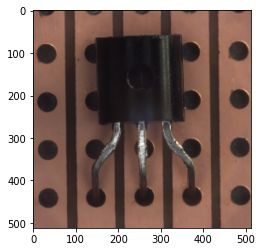

10001 img_size: (256, 256, 3)


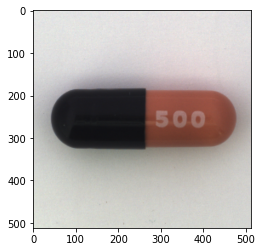

10002 img_size: (256, 256, 3)


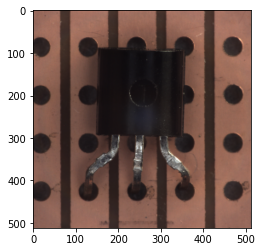

10003 img_size: (256, 256, 3)


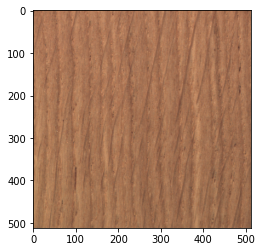

10004 img_size: (256, 256, 3)


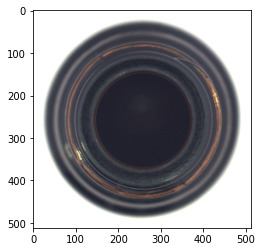

10005 img_size: (256, 256, 3)


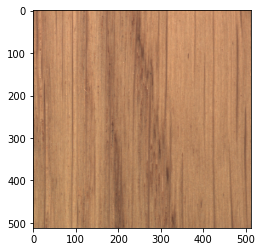

10006 img_size: (256, 256, 3)


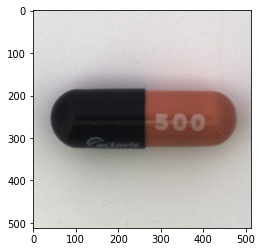

10007 img_size: (256, 256, 3)


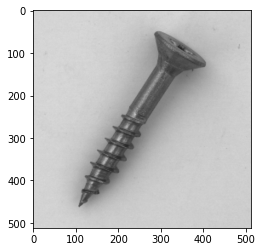

10008 img_size: (256, 256, 3)


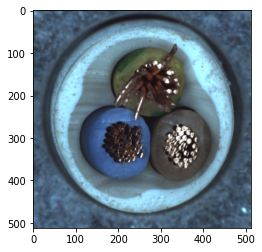

10009 img_size: (256, 256, 3)


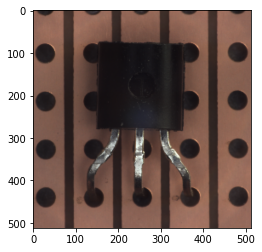

In [8]:
# 이미지 확인
for i in range(10):
  file_name = train_total.file_name.iloc[i]
  img = cv2.imread('/content/drive/MyDrive/colab/data/train_256/' + file_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print(file_name[-9:-4],'img_size:',img.shape)
  img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
  plt.imshow(img)
  plt.show()

In [9]:
pd.DataFrame(train_total[['label']].value_counts())

,0
label,
33,391
55,320
21,280
52,267
28,264
...,...
8,5
71,5
70,5


# 하이퍼파라미터 및 변수

In [10]:
# 학습 변수
device = torch.device("cuda:0")
batch_size = 8
class_n = len(train_total['label'].unique())
learning_rate = 5e-5
epochs = 300
save_path = '16model.pt'

# 데이터셋 구성

In [11]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        if mode == 'train':
            self.labels = labels
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        if self.mode == 'train':
            img = cv2.imread('/content/drive/MyDrive/colab/data/train_256/'+self.files[i])
            # img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255
            
            # 0~3 사이의 임의의 정수 생성
            rand = random.randrange(0,4)
            
            if rand == 0:
              img = img
            elif rand == 1:
              img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전
            elif rand == 2:
              img = cv2.rotate(img, cv2.ROTATE_180) # 180도 회전       
            elif rand == 3:
              img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE) # 시계방향으로 270도 회전
            else:
              img=img
       
            img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'label' : torch.tensor(self.labels[i], dtype=torch.long)
            }
        else:
            img = cv2.imread('/content/drive/MyDrive/colab/data/test_256/'+self.files[i])
            # img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255

            img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
            }

In [12]:
# train:val = 3400:877
train = train_total.iloc[:3400]
val = train_total.iloc[3400:]

In [13]:
train_dataset = CustomDataset(train['file_name'].values, train['label'].values)
val_dataset = CustomDataset(val['file_name'].values, val['label'].values)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

test_dataset = CustomDataset(test['file_name'], labels=None, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# 모델

In [14]:
class CNN_Model(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Model, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.dropout = nn.Dropout(rate)
        self.output_layer = nn.Linear(in_features=1000, out_features=class_n, bias=True)
    
    def forward(self, inputs):
        output = self.output_layer(self.dropout(self.model(inputs)))
        return output

In [15]:
model = CNN_Model(class_n).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 학습

In [17]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
            
        return loss

In [ ]:
loss_plot, val_loss_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if val_loss_plot[-1]<0.04:
        torch.save(model, 'models/16model'+str(epoch+1)+str(val_loss_plot[-1])+'.pt')
    if min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, '16model.pt')

425it [06:37,  1.07it/s, Epoch=1, Loss=1.477970, Total Loss=1.046045]
110it [01:39,  1.11it/s, Epoch=1, Val Loss=0.036645, Total Val Loss=0.870992]
425it [02:25,  2.93it/s, Epoch=2, Loss=0.370248, Total Loss=0.672144]
110it [00:15,  7.27it/s, Epoch=2, Val Loss=0.132100, Total Val Loss=0.633455]
425it [02:24,  2.94it/s, Epoch=3, Loss=1.443863, Total Loss=0.537072]
110it [00:15,  7.28it/s, Epoch=3, Val Loss=0.196769, Total Val Loss=0.554818]
425it [02:25,  2.93it/s, Epoch=4, Loss=0.364007, Total Loss=0.460265]
110it [00:15,  6.89it/s, Epoch=4, Val Loss=0.006978, Total Val Loss=0.483297]
425it [02:24,  2.95it/s, Epoch=5, Loss=0.123454, Total Loss=0.396135]
110it [00:15,  7.26it/s, Epoch=5, Val Loss=0.142228, Total Val Loss=0.397428]
425it [02:24,  2.95it/s, Epoch=6, Loss=0.305295, Total Loss=0.358087]
110it [00:15,  7.27it/s, Epoch=6, Val Loss=0.137011, Total Val Loss=0.406432]
425it [02:24,  2.94it/s, Epoch=7, Loss=0.050250, Total Loss=0.311702]
110it [00:15,  7.22it/s, Epoch=7, Val Loss

# 학습 결과

In [ ]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 추론 및 제출
- models 폴더에 저장된 파일 중 epoch과 val loss를 고려하여 추론에 사용할 모델 선정
- model.pt로 저장한 후 아래 코드 실행

In [ ]:
def predict(dataset):
    model.load_state_dict(torch.load('16model.pt').state_dict())
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    training = False
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        with torch.no_grad():
            output = model(img)
        output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

In [ ]:
preds = predict(test_dataloader)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/colab/data/sample_submission.csv')

In [ ]:
submission.iloc[:,1] = preds

In [ ]:
# memo에 기록할 내용 출력
# 학습에 사용한 모델의 epoch과 val_loss 기록
print('batch_size =',batch_size)
print('learning_rate =',learning_rate)
print('epochs =',259)
print('val_loss =',0.0046)
print('img_size =',str(512))
print('augmentation : random rotation')

In [ ]:
# submission_code : date_number ex) 22일 3번째 제출 : 22_3
submission_code = '25_1'
submission.to_csv(submission_code+'.csv', index=False)

In [ ]:
torch.save(model, '/content/drive/MyDrive/colab/dacon/이상치 탐지 알고리즘 경진대회/'+submission_code+'/model.pt')
submission.to_csv('/content/drive/MyDrive/colab/dacon/이상치 탐지 알고리즘 경진대회/'+submission_code+'/'+submission_code+'.csv', index=False)